## Zadanie domowe - Algorytm Canny'ego

Celem zadania domowego jest wykonanie pełnej implementacji algorytmu Canny'ego.

W ramach ćwiczenia w trakcie laboratorium wyznaczono obrazy $g_{NH}$ i $g_{NL}$.
Dla przypomnienia:
Można powiedzieć, że na obrazie $g_{NH}$ są "pewne" krawędzie.
Natomiast na $g_{NL}$ "potencjalne".
Często krawędzie "pewne" nie są ciągłe.
Wykorzystuje się więc krawędzie "potencjalne", aby uzupełnić nieciągłości.
Procedura wygląda następująco:
1. Stwórz stos zawierający wszystkie piksele zaznaczone na obrazie $g_{NH}$.
W tym celu wykorzystaj listę współrzędnych `[row, col]`.
Do pobrania elementu z początku służy metoda `list.pop()`.
Do dodania elementu na koniec listy służy metoda `list.append(new)`.
2. Stwórz obraz, który będzie zawierał informację czy dany piksel został już odwiedzony.
3. Stwórz obraz, który zawierać będzie wynikowe krawędzie.
Jej rozmiar jest równy rozmiarowi obrazu.
4. Wykonaj pętlę, która będzie pobierać elementy z listy, dopóki ta nie będzie pusta.
W tym celu najlepiej sprawdzi się pętla `while`.
    - W każdej iteracji pobierz element ze stosu.
    - Sprawdź, czy dany element został już odwiedzony.
    - Jeśli nie został, to:
        - Oznacz go jako odwiedzony,
        - Oznacz piksel jako krawędź w wyniku,
        - Sprawdź otoczenie piksela w obrazie $g_{NL}$,
        - Dodaj do stosu współrzędne otoczenia, które zawierają krawędź.
        Można to wykonać np. pętlą po stworzonym otoczeniu.
7. Wyświetl obraz oryginalny, obraz $g_{NH}$ oraz obraz wynikowy.
8. Porównaj wynik algorytmu z wynikiem OpenCV.

Pomocnicze obrazy $g_{NH}$ i $g_{NL}$ zostały wprowadzone dla uproszczenia opisu.
Algorytm można zaimplementować w bardziej "zwarty" sposób.

Na podstawie powyższego opisu zaimplementuj pełny algorytm Canny'ego.

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import os

if not os.path.exists("dom.png") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/09_Canny/dom.png --no-check-certificate
dom = cv2.imread("dom.png", cv2.IMREAD_GRAYSCALE)

In [2]:
def nonmax(direction_table, M):
    X, Y = direction_table.shape
    gn = np.zeros((X,Y))
    for i in range(1, X - 1):
        for j in range(1, Y - 1):
            if direction_table[i][j] == 'd1':
                if M[i + 1][j] > M[i][j] or M[i - 1][j] > M[i][j]:
                    gn[i][j] = 0
                else:
                    gn[i][j] = M[i][j]
            elif direction_table[i][j] == 'd2':
                if M[i][j + 1] > M[i][j] or M[i][j - 1] > M[i][j]:
                    gn[i][j] = 0
                else:
                    gn[i][j] = M[i][j]
            elif direction_table[i][j] == 'd3':
                if M[i - 1][j - 1] > M[i][j] or M[i + 1][j + 1] > M[i][j]:
                    gn[i][j] = 0
                else:
                    gn[i][j] = M[i][j]
            elif direction_table[i][j] == 'd4':
                if M[i - 1][j + 1] > M[i][j] or M[i + 1][j - 1] > M[i][j]:
                    gn[i][j] = 0
                else:
                    gn[i][j] = M[i][j]
    return gn

def canny(image, Tl, Th):
    X, Y = image.shape
    image_gauss = cv2.GaussianBlur(image,(3,3),1.5)
    gx = cv2.Sobel(image_gauss, cv2.CV_64F,1,0,ksize=3)
    gy = cv2.Sobel(image_gauss, cv2.CV_64F,0,1,ksize=3)
    M = np.sqrt(np.power(gx,2) + np.power(gy,2))
    alpha = np.arctan2(gy,gx) * 180 / np.pi
    direction_table = np.full((X,Y),'aa')
    for i in range(X):
        for j in range(Y):
            if  67.5 <= alpha[i][j] <= 112.5 or -112.5 <= alpha[i][j] <= -67.5:
                direction_table[i][j] = 'd1'
            elif -22.5 <= alpha[i][j] <= 22.5 or alpha[i][j] >= 157.5 or alpha[i][j] <= -157.5:
                direction_table[i][j] = 'd2'
            elif 112.5 <= alpha[i][j] <= 157.5 or -67.5 <= alpha[i][j] <= -22.5:
                direction_table[i][j] = 'd3'
            elif 22.5 <= alpha[i][j] <= 67.5 or -157.5 <= alpha[i][j] <= -112.5:
                direction_table[i][j] = 'd4'
    gn = nonmax(direction_table, M)
    gnh = gn >= Th
    gnl = (gn >= Tl) * (gn < Th)
    return gnh, gnl

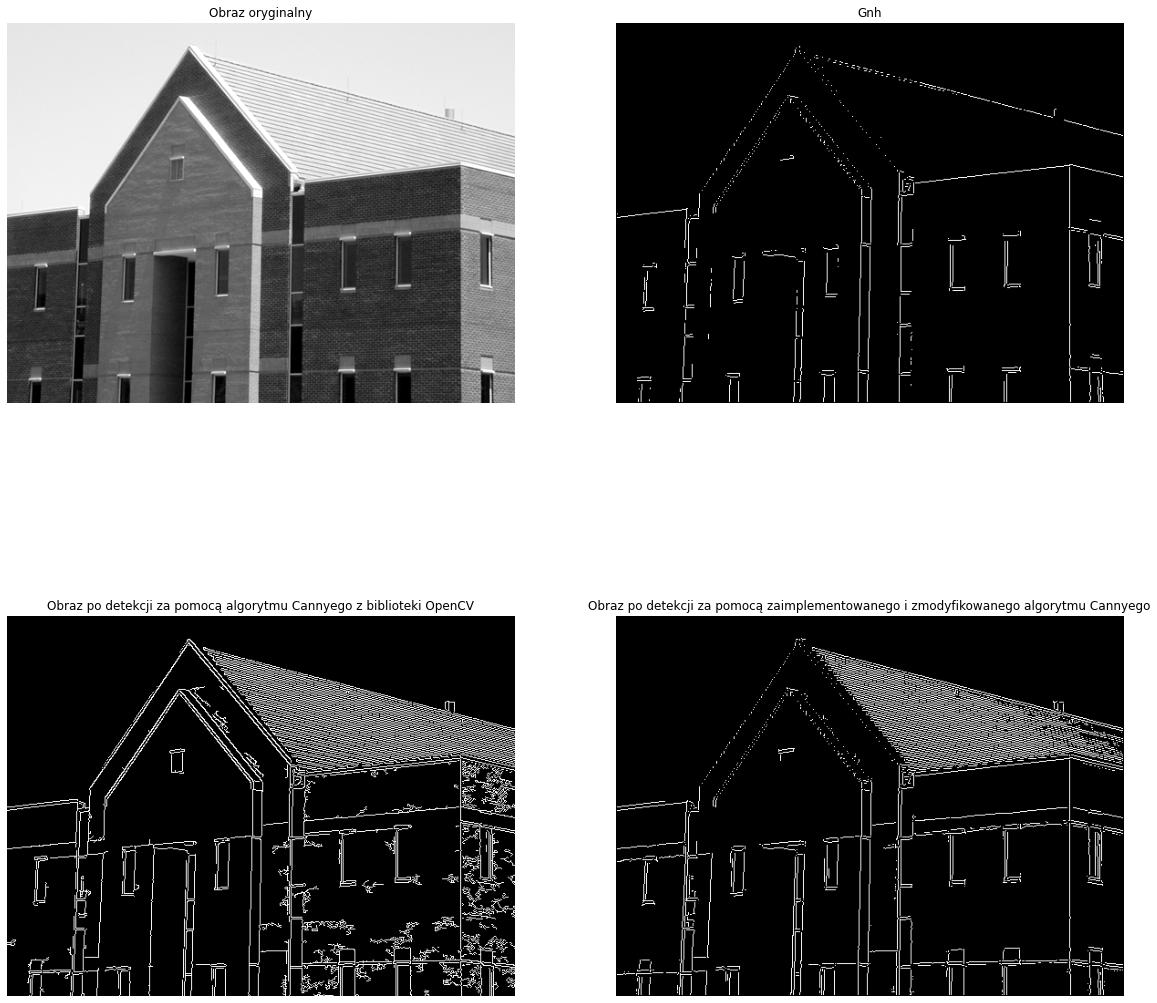

In [3]:
gnh, gnl = canny(dom, 55, 165)
X, Y = dom.shape

stack = []
for i in range(X):
    for j in range(Y):
        if gnh[i][j]:
            stack.append((i,j))

visited_picture = np.full((X,Y),False)
result1 = np.zeros((X, Y))

while stack:
    i, j = stack.pop()
    if not visited_picture[i][j]:
        visited_picture[i][j] = True
        result1[i][j] = 255
        for k in range(-2, 3):
            for l in range(-2, 3):
                if 0 <= i + k < X and 0 <= j + l < Y and gnl[i + k][j + l]:
                    stack.append((i + k, j + l))

result2 = cv2.Canny(dom, 55, 165, None, 3, 1)

fig, ax = plt.subplots(2, 2, figsize=(20,20))
ax[0][0].imshow(dom, 'gray')
ax[0][0].axis('off')
ax[0][0].set_title('Obraz oryginalny')
ax[0][1].imshow(gnh, 'gray')
ax[0][1].axis('off')
ax[0][1].set_title('Gnh')
ax[1][0].imshow(result2, 'gray')
ax[1][0].axis('off')
ax[1][0].set_title('Obraz po detekcji za pomocą algorytmu Cannyego z biblioteki OpenCV')
ax[1][1].imshow(result1, 'gray')
ax[1][1].axis('off')
ax[1][1].set_title('Obraz po detekcji za pomocą zaimplementowanego i zmodyfikowanego algorytmu Cannyego')
plt.show()

Własna implementacja działa poprawnie lecz objawia pewne różnice w stosunku do funkcji z OpenCV. Krawędzie, które wykazywały nieciągłości nadal pozostają przerywane, za to obraz jest pozbawiony większości artefaktów oraz są na nim widoczne nowe, poprawne krawędzie.